In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
sys.path.append('../')
from src.data import train_val_test_split
from src.data import get_descriptor_and_labels

# Sensitivity Analysis

We use permutation feature importance to look at the structural characteristics which play an important role in classifying amorphous ices.

### Load in the training, validation and testing data

In [2]:
train_structs, val_structs, test_structs = train_val_test_split()

In [3]:
numb_train_samples = 8_000
train_x, train_y, label_mapping = get_descriptor_and_labels(train_structs,num_samples_per_type=numb_train_samples)
val_x, val_y, _ = get_descriptor_and_labels(val_structs, num_samples_per_type=2_500)
test_x, test_y, _ = get_descriptor_and_labels(test_structs, num_samples_per_type=2_500)

# need to convert one-hot vectors to integers
train_y = np.argmax(train_y,axis=1)
val_y = np.argmax(val_y,axis=1)
test_y = np.argmax(test_y,axis=1)

In [4]:
# we are going to train 3 binary classifiers
# one for each type of amorphous ice
# we need to convert the labels to be 1 for the type of ice and 0 for the other two
train_ys = []
test_ys = []
for i in range(3):
    train_ys.append(np.where(train_y==i,1,0))
    test_ys.append(np.where(test_y==i,1,0))

### Define the model
We performed sensitivity analysis on two classes on models:

1. **NN** - Fig. 3

We optimised parameters of our NN in [NN_optimisation.ipynb](NN_optimisation.ipynb). 
Here we load in those results and define our network architecture before training.

2. **Random Forest** - Fig. S4

We defined a Random Forest classifier to compare the results with our NN

In [5]:
model_choice = "NN"

In [6]:
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

if model_choice == "NN":
    study_name = "optimise_NN"  # Unique identifier of the study.
    storage_name = f"sqlite:///{study_name}.db"
    study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
    optimised_NN_params = study.best_params

    n_layers, neurons_per_layer, weight_decay, lr = optimised_NN_params.values()
    hidden_layers = [neurons_per_layer] * n_layers
    input_size = 30 # number of features
    output_size = 3 # number of classes (HDA, LDA, MDA)

    model = MLPClassifier(hidden_layer_sizes=hidden_layers,activation='relu',solver='adam',batch_size=200,learning_rate_init=lr,alpha=weight_decay,max_iter=1000)
elif model_choice == "RandomForest":
    model = RandomForestClassifier(random_state=0, n_estimators=300)

[I 2023-12-17 16:13:00,111] Using an existing study with name 'optimise_NN' instead of creating a new one.


### Train the model

In [7]:
from sklearn.inspection import permutation_importance

classification_results = {}
struct_types = ['HDA','LDA','MDA']
for i in range(3):
    model.fit(train_x,train_ys[i])
    result = permutation_importance(model, test_x, test_ys[i], n_repeats=10, random_state=42)
    classification_results[struct_types[i]] = result

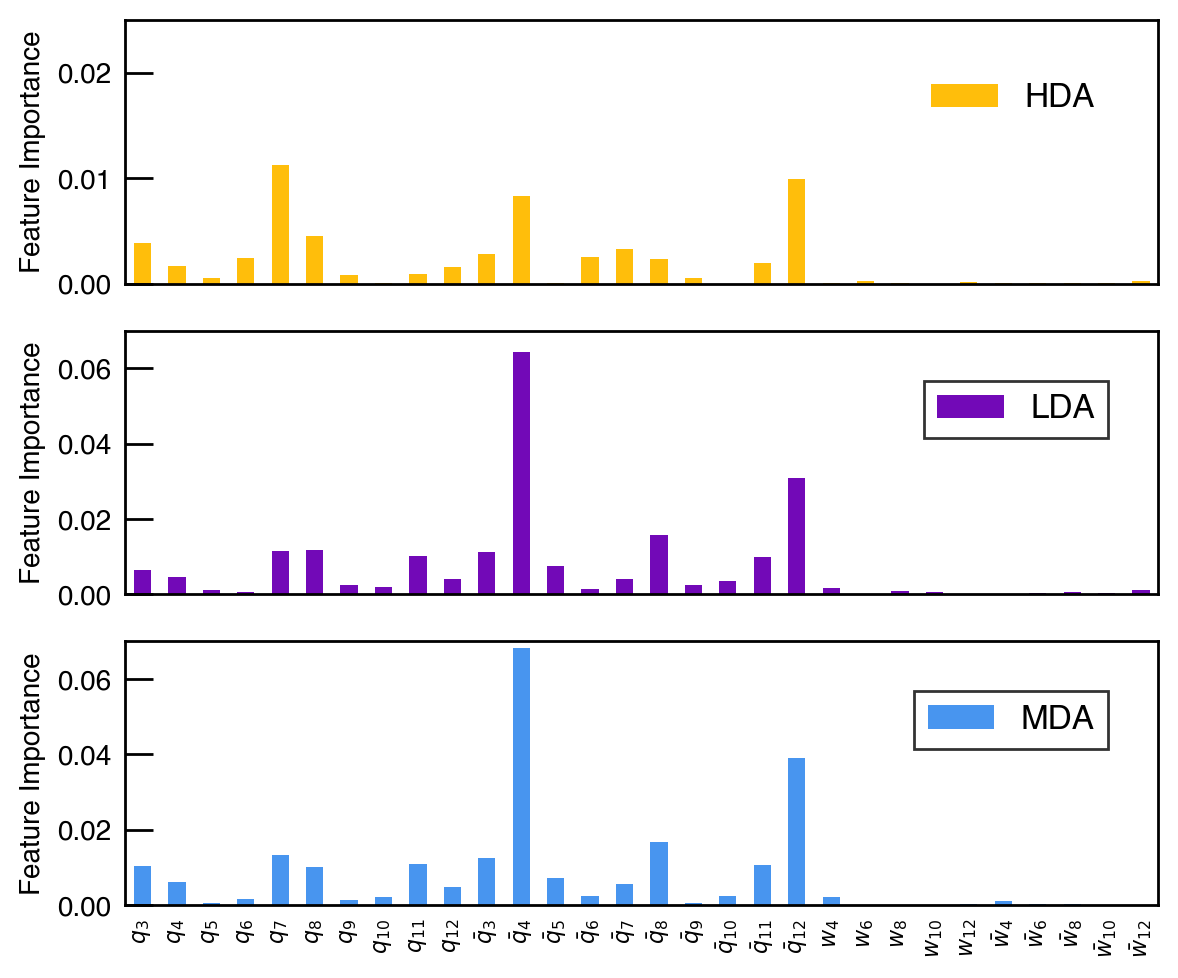

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
from src.steinhardt import desc_to_plot_label_mapping

%config InlineBackend.figure_format = 'retina'
plt.style.use('plot.mplstyle')

labels = ['HDA','LDA','MDA']
colors = ['#ffbe0b','#7209b7','#4895ef']

fig, axs = plt.subplots(3,1,figsize=(6,5),sharex=True)

for i in range(3):
    result = classification_results[struct_types[i]]
    importances = pd.Series(result.importances_mean)
    importances.plot.bar(ax=axs[i],color=colors[i],label=labels[i])
    axs[i].legend()
    axs[i].set_ylabel('Feature Importance')   
axs[0].set_ylim(0,0.025)
axs[1].set_ylim(0,0.07)
axs[2].set_ylim(0,0.07)
   
axs[-1].set_xticks(np.arange(0,30),list(desc_to_plot_label_mapping.values()),fontsize=8);
# reduce length of xtick 
for ax in axs:
    ax.tick_params(axis='x', which='major', pad=5, length=0)
    ax.tick_params(axis='y', which='major', pad=5, labelsize=10)
    # change ytick label size
    

# make plot borders thinner
linewidth = 1
for ax in axs:
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    # ax.get_legend().get_frame().set_linewidth(0.0)
    

# remove the box around the legend
axs[0].get_legend().get_frame().set_linewidth(0.0)

fig.tight_layout()
# plt.savefig('../figures/feature_importance_RandomForest.svg',dpi=300,bbox_inches='tight')